In [1]:
## IMPORTS
import torch

!pip uninstall torch-scatter torch-sparse torch-geometric torch-cluster  --y
!pip install torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-geometric

!pip freeze > requirements.txt
!pip list --format=freeze > requirements.txt

Looking in links: https://data.pyg.org/whl/torch-2.1.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 21.6 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.1.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 17.2 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.1.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 19.1 MB/s eta 0:00:00


In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.nn import Node2Vec
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import to_networkx
from tqdm import tqdm
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.preprocessing import MinMaxScaler

dataset = Planetoid(root='./data', name='Cora')  # Itt 'Cora' helyett használhatsz másik Planetoid adathalmazt is.
data = dataset[0]

In [32]:
## PARAMETERS
embedding_dim = 256
walk_length=40
context_size=40
walks_per_node=10
num_negative_samples=1
p=0.5
q=0.1

lr=0.05
epochs=50
batch_size=64

In [4]:
!pip install wandb
import wandb
wandb.login()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.9/243.9 kB 16.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.3 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8791 sha256=5db644ba18d3c154caebc16dee56a1b503b0e657d6cadb5c835abe3193323f81
  Stored in directory: /root/.cache/pip/wheels/e7/f3/22/152153d6eb222ee7a56ff8617d80ee5207207a8c00a7aab794
Successfully built pathtools


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [33]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Create the Node2Vec model
model = Node2Vec(data.edge_index, embedding_dim, walk_length=walk_length, context_size=context_size,
                 walks_per_node=walks_per_node, num_negative_samples=num_negative_samples, p=p, q=q, sparse=True).to(device)



In [34]:
# Initialize the SGD optimizer with momentum
loader = model.loader(batch_size=batch_size, shuffle=True, num_workers=0)
optimizer = torch.optim.SparseAdam(list(model.parameters()), lr=lr)

def train():
    model.train()
    total_loss = 0
    for pos_rw, neg_rw in loader:
        optimizer.zero_grad()
        loss = model.loss(pos_rw.to(device), neg_rw.to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

@torch.no_grad()
def test():
    model.eval()
    z = model()
    acc = model.test(z[data.train_mask], data.y[data.train_mask], z[data.test_mask], data.y[data.test_mask], max_iter=150)
    return acc

@torch.no_grad()
def plot_points(colors):
    model.eval()
    z = model(torch.arange(data.num_nodes, device=device))
    z = TSNE(n_components=2).fit_transform(z.cpu().numpy())
    y = data.y.cpu().numpy()

    plt.figure(figsize=(10, 10))
    for i in range(dataset.num_classes):
        plt.scatter(z[y == i, 0], z[y == i, 1], s=20, color=colors[i])
    plt.axis('off')
    #plt.label(f'embs_p {p}_q {q}_size {embedding_dim}')
    plt.savefig(f'embs_p {p}_q {q}_size {embedding_dim}.jpg')
    plt.show()

In [35]:
wandb.init(project="project_lab2_node2vec")
for epoch in tqdm(range(epochs)):
    loss = train()
    acc = test()
    wandb.log({"Loss": loss, "Acc": acc, "Epoch": epoch + 1})
wandb.finish()

100%|██████████| 50/50 [00:18<00:00,  2.77it/s]


Acc,▁▅▅▆▆▇██▇██▇▇▇▇▇▇▆▇▇▆▇▇██▇▇▇▇▇▇▇█▇▇▇▇▇▇▇
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Loss,█▅▄▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Acc,0.638
Epoch,50
Loss,1.19415


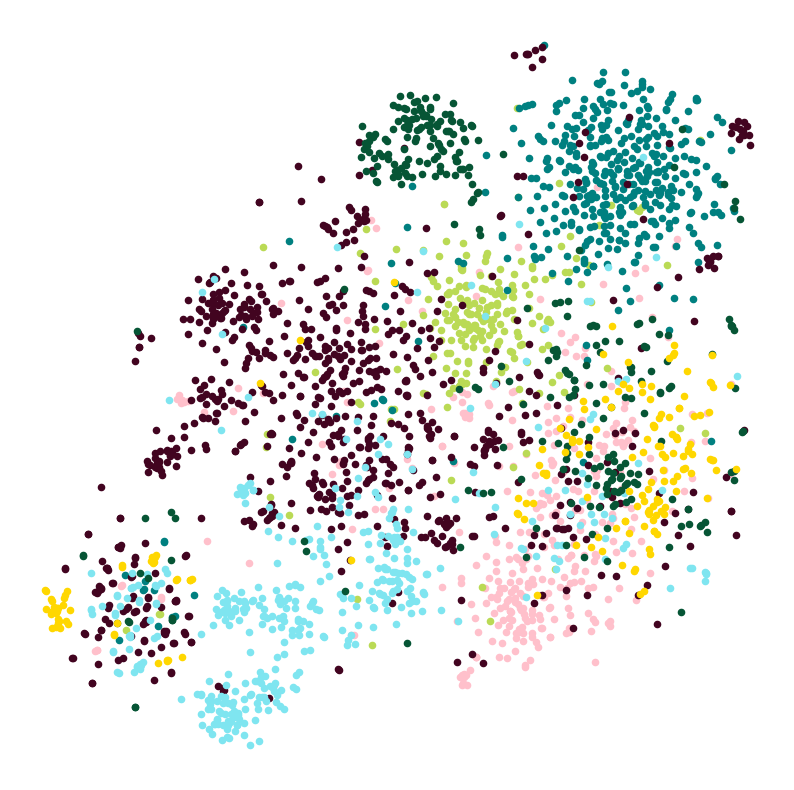

In [36]:
colors = [ '#ffc0cb', '#bada55', '#008080', '#420420', '#7fe5f0', '#065535', '#ffd700' ]
plot_points(colors)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1020: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


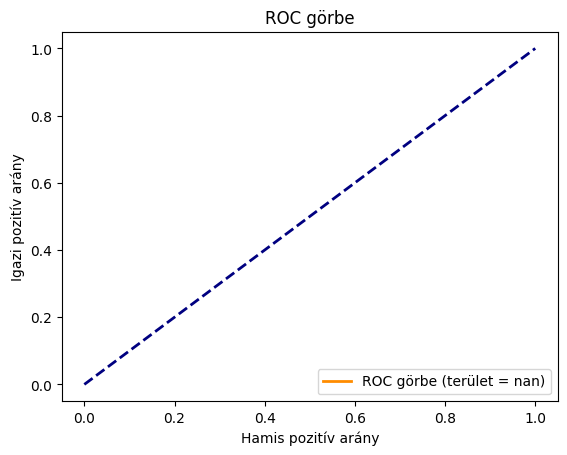

In [ ]:
import numpy as np
import torch
from torch_geometric.datasets import Planetoid
from sklearn.metrics import roc_curve, roc_auc_score, auc
import matplotlib.pyplot as plt

# Planetoid adathalmaz betöltése
dataset = Planetoid(root='./data', name='Cora')  # Használja a megfelelő adathalmaz nevet
data = dataset[0]

# Node2Vec modell beágyazások betöltése
embeddings = model()
embeddings = embeddings.cpu().detach().numpy()
# Az éleket tartalmazó gráf előkészítése
edge_index = data.edge_index

# Gráf mérete
num_nodes = data.num_nodes

# Beágyazások közötti hasonlóság kiszámítása (példában koszinusz hasonlóság)
similarity_matrix = np.dot(embeddings, embeddings.T)

# Pozitív élek előkészítése
positive_edges = data.edge_index.t().numpy()

# Élpredikció számítása
edge_predictions = [similarity_matrix[i, j] for i, j in positive_edges]

# SCALING
#scaler = MinMaxScaler()
#m_scaled = scaler.fit_transform(similarity_matrix)


# Pozitív élek származtatása
y_true = [1] * len(positive_edges)

# ROC görbe számítása
fpr, tpr, treshold = roc_curve(y_true, edge_predictions, pos_label=1)
roc_auc = auc(fpr, tpr)

# ROC görbe ábrázolása
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC görbe (terület = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
#plt.xlim([0.0, 1.0])
#plt.ylim([0.0, 1.05])
plt.xlabel('Hamis pozitív arány')
plt.ylabel('Igazi pozitív arány')
plt.title('ROC görbe')
plt.legend(loc='lower right')
plt.show()

In [ ]:
tpr

array([0.00000000e+00, 1.89465707e-04, 1.00000000e+00])

In [ ]:
## Classifier using Linear Regression on Planetoid dataset

In [ ]:
## Metrics: Confusion Matrix, F1 score (micro/macro), Accuracy